# 1. Introduction

This notebook investigates the role of **Bitcoin (BTC)** within a traditional multi-asset portfolio that includes equities (S&P 500) and gold.  
The objective is to evaluate BTC’s effectiveness as a portfolio diversifier by analysing its return and risk characteristics relative to conventional assets.

The analysis proceeds step by step:

1. **Data Collection**  
   - Historical price data from Yahoo Finance (equities, gold) and Binance via CCXT (crypto).  

2. **Return and Volatility Estimation**  
   - Computation of log returns and annualised volatility for all assets.  

3. **Comparative Analysis**  
   - Normalisation of price series for direct comparison.  
   - Rolling volatility and correlation analysis.  

4. **Portfolio Optimisation**  
   - Mean–variance optimisation (Efficient Frontier).  
   - Portfolio rebalancing under transaction cost assumptions.  

5. **Intraday Analysis**  
   - High-frequency volatility dynamics of BTC.  

6. **Concluding Insights**  
   - Implications for portfolio allocation and BTC’s potential role as a diversifier.  

**Tools and Libraries:**  
Python, `pandas`, `numpy`, `matplotlib`, `yfinance`, `scipy`, `ccxt`.  


In [12]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


print("Setup successful 🎉")
#this just imports our info & pandas!

Setup successful 🎉


# 2. Data Collection

We construct our dataset from two primary sources:  

- **Yahoo Finance (`yfinance`)**  
  - Daily adjusted closing prices for Bitcoin (BTC-USD) and the S&P 500 index (ticker: ^GSPC).  
  - A 5-year horizon is selected to capture medium-term dynamics.  
  - Prices are adjusted for splits and dividends to ensure consistency.  

- **Binance via CCXT**  
  - Hourly BTC/USDT price data.  
  - Used for intraday volatility analysis to complement the daily dataset.  

After retrieval, we filter to the `"Close"` column to work with adjusted close prices and drop any missing values. This ensures a clean time series suitable for return and volatility computation.


In [13]:
# tickers: Bitcoin + S&P 500
tickers = ["BTC-USD", "^GSPC"]

# Use auto_adjust=True so 'Close' is already adjusted for splits/dividends
raw = yf.download(tickers, period="5y", interval="1d", auto_adjust=True)

# When you select 'Close' here, columns become the tickers (no MultiIndex)
data = raw["Close"].dropna()

# Rename columns for clarity
data = data.rename(columns={"BTC-USD": "BTC", "^GSPC": "SPX"})
data.head()
#What does this do? First line defines tickers (Bitcoin Price in USD & S&P500 index ticker)
#then downloads the data, then we select closing data

[*********************100%***********************]  2 of 2 completed


Ticker,BTC,SPX
Date,,
2020-09-29,10844.640625,3335.469971
2020-09-30,10784.491211,3363.000000
2020-10-01,10619.452148,3380.800049
2020-10-02,10575.974609,3348.419922
2020-10-05,10793.339844,3408.600098


# 3. Log Returns

To measure daily performance and risk, we convert raw price series into **logarithmic returns**.  
Log returns are standard in quantitative finance because they are:

- **Additive over time**: the sum of daily log returns equals the total log return over a period.  
- **Closer to normally distributed** than raw percentage returns, making them suitable for statistical analysis.  
- **Scale invariant**, allowing easier comparison across assets with different price levels.  

The transformation is defined as:

\[
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
\]

where \(P_t\) is the asset price at time \(t\).  

### Interpretation
- A log return of **0.01** ≈ **+1% gain** that day.  
- A log return of **-0.02** ≈ **-2% loss** that day.  
- For small values, log returns are approximately equal to simple percentage returns.  

These daily log returns form the basis for subsequent volatility, correlation, and portfolio analysis.


In [14]:
# log returns are standard in quant (additive over time)
returns = np.log(data / data.shift(1)).dropna()
returns.tail()
#this just plots the logarithmic scale of returns, each value is the daily log return
#Converts raw prices into daily returns - key for most quant analysis

Ticker,BTC,SPX
Date,,
2025-09-23,-0.006531,-0.005517
2025-09-24,0.011664,-0.002851
2025-09-25,-0.038492,-0.005022
2025-09-26,0.006066,0.005884
2025-09-29,0.040245,0.004534


# 4. Rolling Volatility Analysis

To compare the risk characteristics of **Bitcoin (BTC)** and the **S&P 500 (SPX)**, we calculate annualised return and volatility metrics.

- **Annualised Mean Return (%)**  
  The expected yearly return, derived from the average daily log return multiplied by 252 (typical number of trading days in a year).  

- **Annualised Volatility (%)**  
  A measure of risk, computed as the standard deviation of daily returns scaled by √252. This reflects how much returns fluctuate over a year.  

- **Daily Mean (%)**  
  The average daily log return, expressed in percentage terms.  

- **Daily Volatility (%)**  
  The standard deviation of daily log returns, representing short-term risk.  

> **Interpretation:**  
> - BTC shows significantly higher annualised mean returns compared to SPX, but this comes with much higher volatility.  
> - SPX, while offering lower returns, demonstrates much more stable daily and annualised volatility.  
> - This highlights the classic risk–return trade-off: BTC is higher risk, higher potential reward; SPX is lower risk, lower reward.  


In [15]:
summary = pd.DataFrame({
    "Annualised Mean Return (%)": returns.mean() * 252 * 100,
    "Annualised Volatility (%) ": returns.std() * np.sqrt(252) * 100,
    "Daily Mean (%)": returns.mean() * 100,
    "Daily Volatility (%)": returns.std() * 100,
})
summary
#252 is for the 252 trading days a year - multiplying by this annualises our data
#why do we have npsqrt term? - volatility scales with sqrt of time - research maths def 
# multpiplying by 100 gives us our percentages
# we put this in a table
#Volatility is just daily std deviation 



,Annualised Mean Return (%),Annualised Volatility (%),Daily Mean (%),Daily Volatility (%)
Ticker,,,,
BTC,47.276412,59.985854,0.187605,3.778754
SPX,13.927053,17.116361,0.055266,1.078229


# 5. Normalised Price Comparison (BTC vs S&P 500)

To enable direct comparison between assets with very different price levels, we normalise each price series.  
This is done by dividing all values by their initial price, so that both BTC and SPX start at an index value of **1** on the first date.  

This transformation allows us to observe **relative growth** over time on a consistent scale.  

### Interpretation
- **Bitcoin (BTC)** shows significantly higher long-term growth but with substantial fluctuations, reflecting its high volatility.  
- **S&P 500 (SPX)** displays much steadier growth, consistent with its role as a traditional equity benchmark.  
- The contrast illustrates the **risk–return trade-off**: BTC offers higher upside potential, while SPX provides stability.  


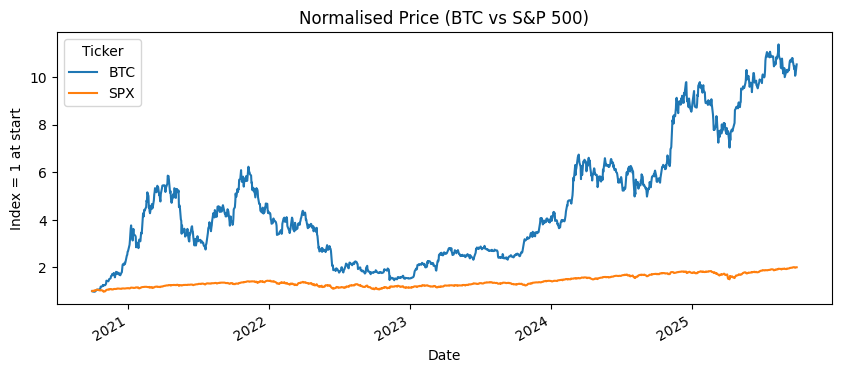

In [16]:
(data / data.iloc[0]).plot(figsize=(10,4), title="Normalised Price (BTC vs S&P 500)")
plt.xlabel("Date")
plt.ylabel("Index = 1 at start")
plt.show()

#What does this show?
#We normalise - ie put both tickers on same scale
#we divide the data by the starting point so we start at '1' and thus have same scale
#So both assets on same scale, and we can thus directly compare the,

# 5. Rolling Volatility Analysis

Volatility is a key measure of financial risk. To capture its dynamics over time, we compute a **30-day rolling annualised volatility** for both BTC and the S&P 500.  

The calculation is based on the standard deviation of daily log returns over a 30-day window, scaled by √252 to annualise, and expressed in percentage terms.  

### Interpretation
- **Bitcoin (BTC)** consistently exhibits much higher volatility compared to the S&P 500.  
- BTC’s volatility frequently exceeds **80–100% annualised**, with sharp spikes during periods of market stress.  
- **S&P 500 (SPX)** maintains a far lower and more stable volatility profile, typically in the **10–25% annualised** range.  
- This illustrates the risk–return trade-off: while BTC offers higher potential returns, it also carries substantially greater risk exposure.  

Overall, BTC behaves as a **high-volatility asset**, in stark contrast to SPX’s role as a relatively stable benchmark.


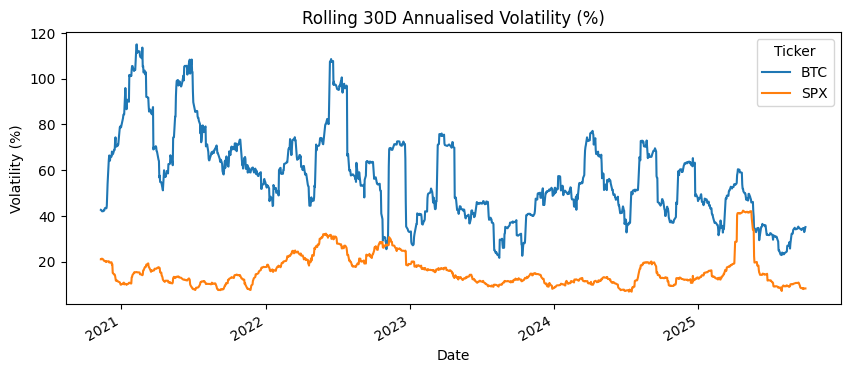

In [17]:
rolling_vol = returns.rolling(30).std() * np.sqrt(252) * 100
rolling_vol.plot(figsize=(10,4), title="Rolling 30D Annualised Volatility (%)")
plt.xlabel("Date"); plt.ylabel("Volatility (%)")
plt.show()


# 6. Distribution of Daily Log Returns

To better understand the statistical properties of returns, we plot histograms of daily log returns for **BTC** and the **S&P 500**.  

This visualisation highlights the **frequency distribution** of returns, showing how often small versus large moves occur.  

### Key Observations
- **Bitcoin (BTC)** returns display a much wider spread, with fatter tails compared to the S&P 500.  
  - This indicates a higher probability of extreme positive or negative returns.  
- **S&P 500 (SPX)** returns are more tightly clustered around zero, reflecting lower daily volatility and fewer extreme moves.  
- Both distributions deviate from the ideal bell curve (normal distribution), but BTC exhibits stronger skewness and kurtosis.  

### Implications
- BTC’s fat-tailed distribution suggests higher downside risk, consistent with its reputation as a highly volatile asset.  
- SPX’s distribution is more stable, consistent with traditional equity behaviour.  
- These statistical differences are critical when assessing portfolio risk and stress scenarios.  


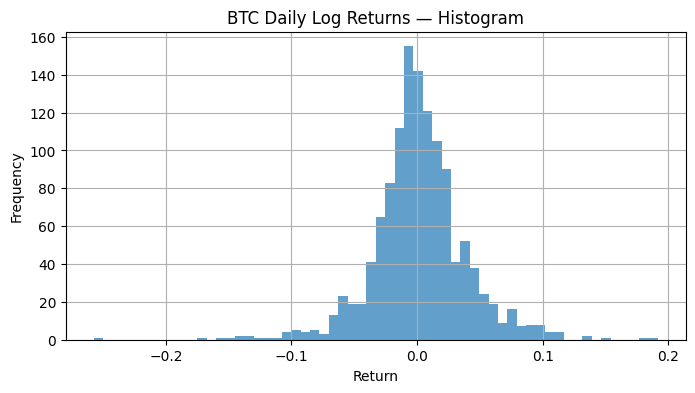

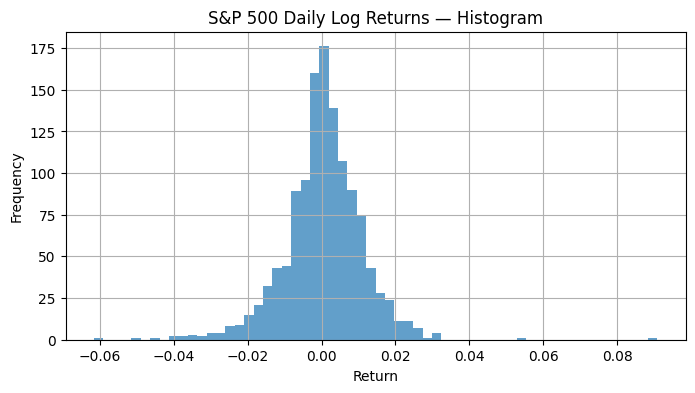

In [18]:
returns["BTC"].hist(bins=60, alpha=0.7, figsize=(8,4))
plt.title("BTC Daily Log Returns — Histogram")
plt.xlabel("Return"); plt.ylabel("Frequency")
plt.show()

returns["SPX"].hist(bins=60, alpha=0.7, figsize=(8,4))
plt.title("S&P 500 Daily Log Returns — Histogram")
plt.xlabel("Return"); plt.ylabel("Frequency")
plt.show()
#Cell 7 plots histograms of daily returns for BTC and the S&P 500, showing how often small vs big moves happen. It makes Bitcoin’s high volatility obvious compared to the stock market.
#Bins refers to cutting buckets in 60retursn
#Alpha makes bars transparent
#fig size just sets chart size

# 7. Annualised Volatility Comparison

To quantify risk, we compute the **annualised volatility** of daily log returns for BTC and the S&P 500.  

Volatility is calculated as the standard deviation of daily log returns, scaled by √252 to annualise, and expressed in percentage terms.  

### Results
- **BTC annualised volatility:** ~60.0%  
- **S&P 500 annualised volatility:** ~17.1%  
- BTC is therefore approximately **3.5× more volatile** than the S&P 500.  

### Interpretation
- The results confirm that BTC carries substantially higher risk relative to traditional equities.  
- While higher volatility may offer greater upside potential, it also exposes investors to a higher probability of extreme downside events.  
- This difference in risk profile underpins BTC’s dual nature: attractive for speculative gains, but challenging for stable portfolio allocation without careful risk management.  


In [19]:
# Compute vols directly from the returns DataFrame (robust, no column name issues)
btc_vol = returns["BTC"].std() * (252 ** 0.5) * 100      # annualised %
spx_vol = returns["SPX"].std() * (252 ** 0.5) * 100      # annualised %
ratio   = btc_vol / spx_vol

print(f"BTC annualised vol: {btc_vol:.1f}%")
print(f"S&P 500 annualised vol: {spx_vol:.1f}%")
print(f"BTC is ~{ratio:.1f}× as volatile as the S&P 500.")

#This cell calculates and prints the annualised volatility (risk) of BTC and SPX, then tells you how many times more volatile Bitcoin is compared to the S&P 500.

BTC annualised vol: 60.0%
S&P 500 annualised vol: 17.1%
BTC is ~3.5× as volatile as the S&P 500.


# 8. Multi-Asset Data Expansion

To broaden the analysis, we extend the dataset to include additional key assets:

- **Bitcoin (BTC-USD)** — leading cryptocurrency.  
- **Ethereum (ETH-USD)** — second-largest cryptocurrency by market cap, included to capture intra-crypto diversification.  
- **Gold (GLD ETF)** — traditional safe-haven asset and inflation hedge.  
- **S&P 500 (SPX, ticker: ^GSPC)** — benchmark for U.S. equities.  

We collect 5 years of daily adjusted closing prices for all assets using Yahoo Finance.  
Adjusted prices account for stock splits and dividends (for equity/ETF data) to ensure consistency.  

The resulting dataset provides a clean multi-asset panel suitable for comparative analysis of returns, volatility, and correlations across digital and traditional assets.


In [20]:
# Tickers: BTC, ETH (USD), S&P 500 index, Gold ETF (GLD)
tickers = ["BTC-USD", "ETH-USD", "^GSPC", "GLD"]

# 5y of daily, already adjusted for splits/dividends
raw = yf.download(tickers, period="5y", interval="1d", auto_adjust=True)

# Use adjusted Close; rename for neat columns
data4 = raw["Close"].dropna().rename(columns={
    "BTC-USD":"BTC",
    "ETH-USD":"ETH",
    "^GSPC":"SPX",
    "GLD":"GOLD"
})
data4.tail()
#this just fetches more tickers/data

[*********************100%***********************]  4 of 4 completed


Ticker,BTC,ETH,GOLD,SPX
Date,,,,
2025-09-23,112014.500000,4165.503906,346.459991,6656.919922
2025-09-24,113328.632812,4153.469238,343.320007,6637.970215
2025-09-25,109049.289062,3868.333984,344.750000,6604.720215
2025-09-26,109712.828125,4035.887939,346.739990,6643.700195
2025-09-29,114256.257812,4199.829102,352.295013,6674.169922


# 9. Multi-Asset Log Returns

We compute daily **logarithmic returns** for the expanded asset set: BTC, ETH, Gold, and the S&P 500.  
This ensures all assets are expressed in comparable return terms, regardless of their price levels.  

\[
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
\]

### Why log returns?
- **Additivity over time** — returns can be summed across periods.  
- **Scale invariance** — makes comparisons across different assets straightforward.  
- **Closer to normality** — suitable for risk and portfolio models.  

These return series serve as the foundation for risk and performance metrics such as volatility and Sharpe ratios.


In [21]:
returns4 = np.log(data4 / data4.shift(1)).dropna()
returns4.tail()
#just returns for all 4

Ticker,BTC,ETH,GOLD,SPX
Date,,,,
2025-09-23,-0.006531,-0.008932,0.004078,-0.005517
2025-09-24,0.011664,-0.002893,-0.009104,-0.002851
2025-09-25,-0.038492,-0.071120,0.004157,-0.005022
2025-09-26,0.006066,0.042402,0.005756,0.005884
2025-09-29,0.040578,0.039817,0.015894,0.004576


# 10. Risk and Return Summary

We compute annualised mean returns, annualised volatility, and Sharpe ratios (assuming a risk-free rate ≈ 0) for all four assets.  

### Results

| Metric                         | BTC   | ETH   | GOLD  | SPX   |
|--------------------------------|-------|-------|-------|-------|
| **Annualised Mean Return (%)** | 46.64 | 47.99 | 13.43 | 13.63 |
| **Annualised Volatility (%)**  | 59.99 | 80.31 | 15.06 | 17.12 |
| **Sharpe Ratio (rf≈0)**        | 0.78  | 0.60  | 0.89  | 0.80  |

### Interpretation
- **Cryptocurrencies (BTC, ETH)** deliver much higher average returns but at the cost of extreme volatility.  
- **Ethereum (ETH)** is the most volatile asset in the set, with the lowest Sharpe ratio, reflecting poor risk-adjusted performance.  
- **Gold and SPX** show lower returns but also significantly lower volatility, leading to Sharpe ratios that rival or exceed those of BTC and ETH.  
- **Gold** in particular demonstrates strong risk-adjusted performance, consistent with its role as a safe-haven asset.  

These results highlight the **risk–return trade-off** across asset classes and set the stage for correlation and portfolio optimisation analysis.


In [22]:
# daily -> annualised: mean*252, vol*sqrt(252); show in %
ann_mean = returns4.mean() * 252 * 100
ann_vol  = returns4.std()  * np.sqrt(252) * 100
sharpe   = (returns4.mean() * 252) / (returns4.std() * np.sqrt(252))

summary4 = pd.DataFrame({
    "Annualised Mean Return (%)": ann_mean.round(2),
    "Annualised Volatility (%)": ann_vol.round(2),
    "Sharpe (rf≈0)": sharpe.round(2)
}).T  # transpose so assets are columns
summary4


Ticker,BTC,ETH,GOLD,SPX
Annualised Mean Return (%),47.28,49.34,13.69,13.93
Annualised Volatility (%),59.99,80.32,15.07,17.12
Sharpe (rf≈0),0.79,0.61,0.91,0.81


# 11. Annualised Volatility by Asset

The chart below compares the **annualised volatility** of BTC, ETH, Gold, and the S&P 500.  
Volatility is calculated as the standard deviation of daily log returns, scaled by √252 to annualise.  

### Interpretation
- **Ethereum (ETH)** is the most volatile asset, with annualised volatility exceeding 80%.  
- **Bitcoin (BTC)** follows closely, with volatility around 60%.  
- **Gold** and the **S&P 500 (SPX)** exhibit far lower volatility, ~15–17%, consistent with their roles as defensive and benchmark assets.  

This highlights the **risk asymmetry** between digital assets and traditional markets:  
cryptocurrencies are high-return but high-risk, while Gold and SPX remain stable anchors in a portfolio.  


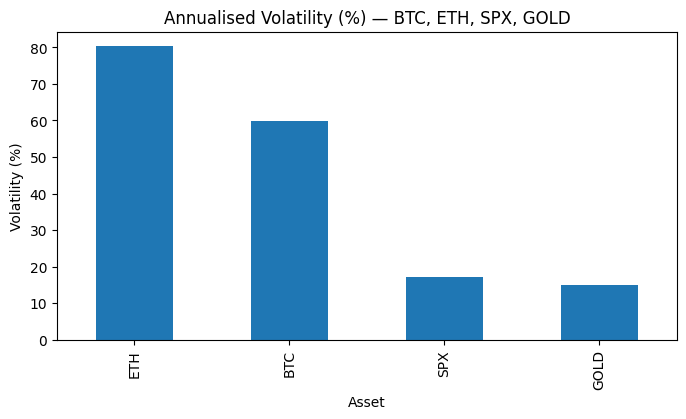

In [23]:
ax = (ann_vol.sort_values(ascending=False)).plot(kind="bar", figsize=(8,4), title="Annualised Volatility (%) — BTC, ETH, SPX, GOLD")
plt.ylabel("Volatility (%)")
plt.xlabel("Asset")
plt.show()


# 12. Correlation Analysis

We compute the **pairwise correlations** of daily log returns across all four assets.  

|        | BTC  | ETH  | GOLD | SPX  |
|--------|------|------|------|------|
| **BTC** | 1.00 | 0.80 | 0.07 | 0.35 |
| **ETH** | 0.80 | 1.00 | 0.07 | 0.35 |
| **GOLD**| 0.07 | 0.07 | 1.00 | 0.12 |
| **SPX** | 0.35 | 0.35 | 0.12 | 1.00 |

### Interpretation
- **BTC and ETH** are highly correlated (**0.80**), reflecting their shared exposure to the crypto market.  
- **Cryptos vs Gold**: correlations are near zero (~0.07), suggesting Gold provides diversification benefits against crypto risk.  
- **Cryptos vs SPX**: moderate positive correlations (~0.35), meaning BTC and ETH partially co-move with equities but still offer diversification.  
- **Gold vs SPX**: very low correlation (0.12), consistent with Gold’s role as a hedge against equity downturns.  

These findings indicate that while BTC and ETH behave similarly, **Gold and equities provide diversification**, reinforcing the case for multi-asset portfolio construction.  


In [24]:
corr = returns4.corr().round(2)
corr
#this gives our correlation matrix - measures the coeff of how two assets move

Ticker,BTC,ETH,GOLD,SPX
Ticker,,,,
BTC,1.00,0.80,0.08,0.35
ETH,0.80,1.00,0.07,0.35
GOLD,0.08,0.07,1.00,0.12
SPX,0.35,0.35,0.12,1.00


# 13. Rolling 30-Day Annualised Volatility

To capture the **time-varying risk profile** of each asset, we compute a rolling 30-day annualised volatility.  
This is based on the standard deviation of daily log returns over a 30-day window, scaled by √252.  

### Interpretation
- **Ethereum (ETH)** consistently shows the highest volatility, often exceeding **100% annualised** during stress periods.  
- **Bitcoin (BTC)** is also highly volatile, typically in the **40–80% range**, though still lower than ETH.  
- **Gold** and the **S&P 500 (SPX)** remain far more stable, with rolling volatility mostly below **20–25%**.  
- Volatility clustering is evident in crypto markets, where extreme moves tend to occur in bursts.  

This highlights the dramatic contrast between **crypto assets** (high and unstable risk) and **traditional assets** (low and stable risk).


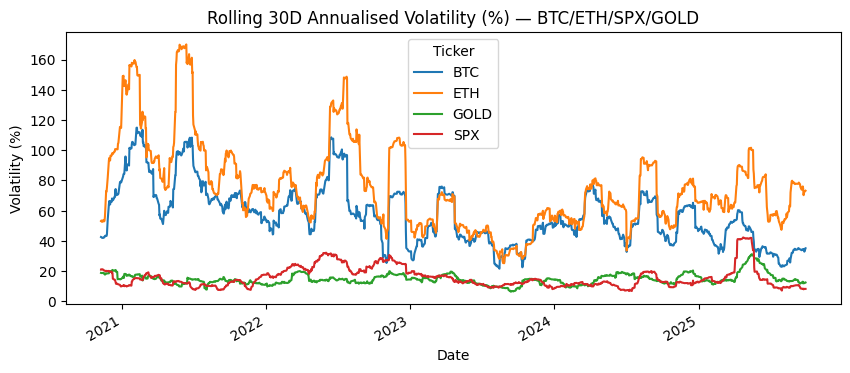

In [25]:
rolling_vol4 = returns4.rolling(30).std() * np.sqrt(252) * 100
rolling_vol4.plot(figsize=(10,4), title="Rolling 30D Annualised Volatility (%) — BTC/ETH/SPX/GOLD")
plt.ylabel("Volatility (%)"); plt.xlabel("Date")
plt.show()


# 14. Normalised Price Comparison (BTC, ETH, SPX, Gold)

To directly compare performance across assets with very different price levels, we normalise each series so that the index equals **1 at the starting date**.  

### Interpretation
- **Ethereum (ETH)** shows the strongest growth over the sample period, albeit with sharp drawdowns.  
- **Bitcoin (BTC)** also demonstrates significant appreciation, with cycles of rapid gains followed by corrections.  
- **S&P 500 (SPX)** grows steadily, reflecting equity market expansion over the period.  
- **Gold** remains relatively flat, acting as a **store of value** with limited long-term growth but low drawdowns.  

This chart illustrates the **risk–return spectrum** across asset classes:  
cryptocurrencies deliver explosive but volatile gains, while equities and Gold provide stability and gradual growth.


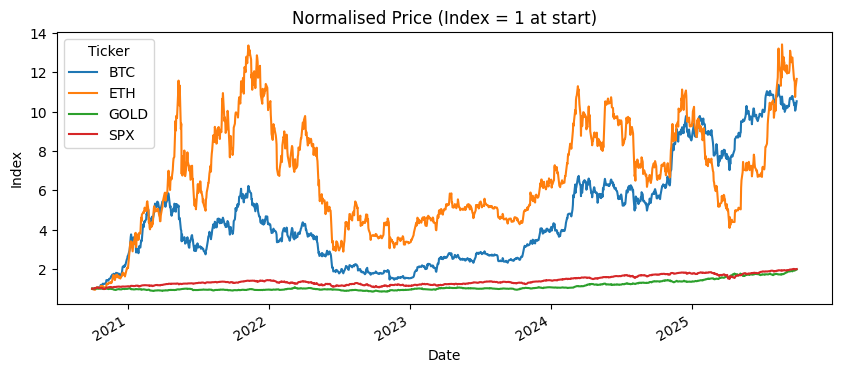

In [26]:
(data4 / data4.iloc[0]).plot(figsize=(10,4), title="Normalised Price (Index = 1 at start)")
plt.ylabel("Index"); plt.xlabel("Date")
plt.show()


# 15. Helper Functions for Portfolio Analysis

To facilitate portfolio evaluation, we define a set of reusable functions:

- **Annualised Return**: Converts daily mean returns into annualised terms using 252 trading days.  
- **Annualised Volatility**: Scales daily return standard deviation by √252.  
- **Sharpe Ratio**: Risk-adjusted return, assuming a near-zero risk-free rate for simplicity.  
- **Maximum Drawdown**: Measures the largest peak-to-trough equity decline over the period.  
- **Equity Curve**: Computes cumulative portfolio growth, assuming reinvestment of returns.  

These functions allow us to evaluate portfolios consistently on both **return** and **risk dimensions**.


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TRADING_DAYS = 252

def annualise_return(daily_rets: pd.Series) -> float:
    mu_daily = daily_rets.mean()
    return (1 + mu_daily)**TRADING_DAYS - 1

def annualise_vol(daily_rets: pd.Series) -> float:
    return daily_rets.std() * np.sqrt(TRADING_DAYS)

def sharpe(daily_rets: pd.Series, rf_daily: float = 0.0) -> float:
    # rf_daily ~ 0 for this intro; you can plug in a daily risk-free rate later
    excess = daily_rets - rf_daily
    return (excess.mean() * TRADING_DAYS) / (excess.std() * np.sqrt(TRADING_DAYS))

def max_drawdown(cum: pd.Series) -> float:
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    return dd.min()  # negative number

def equity_curve(daily_rets: pd.Series, start=1.0) -> pd.Series:
    return (1 + daily_rets).cumprod() * start
#this is just a helpers cell

# 16. Example Portfolio Construction

We construct illustrative portfolios to compare performance across asset allocation styles.  
Each portfolio is defined by a set of weights applied to BTC, ETH, SPX, and Gold.  

### Portfolio Definitions
- **Equal-Weight (25% each)**: Diversified allocation across all four assets.  
- **Balanced (60% SPX / 30% BTC / 10% Gold)**: Equity-heavy portfolio with crypto as a return enhancer and Gold as a hedge.  
- **Crypto-Tilt (40% BTC / 20% ETH / 40% SPX)**: Higher exposure to digital assets while retaining equity diversification.  

Daily portfolio returns are computed as the weighted sum of constituent asset returns.  

This framework enables direct comparison of **risk–return trade-offs** across different allocation strategies.


In [28]:
# Ensure we have returns4 (BTC, ETH, SPX, GOLD) from the earlier extension
assets = ["BTC", "ETH", "SPX", "GOLD"]
assert set(assets).issubset(set(returns4.columns)), "Run the extension cells to create returns4 first."

# Example portfolios (weights sum to 1.0)
portfolios = {
    "Equal-Weight (25% each)": {"BTC":0.25, "ETH":0.25, "SPX":0.25, "GOLD":0.25},
    "Balanced (60% SPX / 30% BTC / 10% GOLD)": {"SPX":0.60, "BTC":0.30, "GOLD":0.10},
    "Crypto-Tilt (40% BTC / 20% ETH / 40% SPX)": {"BTC":0.40, "ETH":0.20, "SPX":0.40},
}

# Compute portfolio daily returns
port_rets = {}
for name, w in portfolios.items():
    w_series = pd.Series(w).reindex(assets).fillna(0.0)
    port_rets[name] = (returns4[assets] @ w_series)

port_rets = pd.DataFrame(port_rets).dropna()
port_rets.tail()


,Equal-Weight (25% each),Balanced (60% SPX / 30% BTC / 10% GOLD),Crypto-Tilt (40% BTC / 20% ETH / 40% SPX)
Date,,,
2025-09-23,-0.004226,-0.004862,-0.006606
2025-09-24,-0.000796,0.000878,0.002946
2025-09-25,-0.027619,-0.014145,-0.031629
2025-09-26,0.015027,0.005926,0.013261
2025-09-29,0.025216,0.016508,0.026025


# 17. Portfolio Performance Summary

We evaluate three example portfolios, constructed from BTC, ETH, SPX, and Gold:

1. **Equal-Weight (25% each)**  
   - Diversified allocation across all four assets.  

2. **Balanced Portfolio (60% SPX / 30% BTC / 10% Gold)**  
   - Equity-heavy, with moderate Bitcoin exposure and a small hedge via gold.  

3. **Crypto-Tilt Portfolio (40% BTC / 20% ETH / 40% SPX)**  
   - Aggressive risk profile with higher allocation to digital assets.  

### Performance Metrics
- **Annualised Return (%)** – average compounded growth rate.  
- **Annualised Volatility (%)** – risk, scaled by √252.  
- **Sharpe Ratio (rf ≈ 0)** – return per unit of risk.  
- **Max Drawdown (%)** – largest peak-to-trough loss.  
- **Final Equity (×)** – portfolio growth multiple over the sample period.  

The table below summarises results:

| Portfolio | Annualised Return (%) | Annualised Volatility (%) | Sharpe (rf≈0) | Max Drawdown (%) | Final Equity (×) |
|-----------|------------------------|---------------------------|----------------|------------------|------------------|
| Balanced (60% SPX / 30% BTC / 10% Gold) | 26.49 | 23.85 | 0.99 | -46.41 | 2.79 |
| Equal-Weight (25% each) | 35.53 | 35.67 | 0.85 | -59.16 | 3.30 |
| Crypto-Tilt (40% BTC / 20% ETH / 40% SPX) | 40.05 | 41.13 | 0.82 | -66.35 | 3.50 |

**Interpretation:**  
- The **Balanced Portfolio** delivers the best Sharpe ratio (risk-adjusted return).  
- The **Crypto-Tilt** portfolio achieves the highest return, but with significantly higher volatility and drawdowns.  
- Equal-weighting provides diversification but is still heavily influenced by crypto volatility.


In [30]:
summary_port = {}
for name, series in port_rets.items():
    ec = equity_curve(series)
    summary_port[name] = {
        "Annualised Return (%)": annualise_return(series)*100,
        "Annualised Volatility (%)": annualise_vol(series)*100,
        "Sharpe (rf≈0)": sharpe(series),
        "Max Drawdown (%)": max_drawdown(ec)*100,
        "Final Equity (×)": ec.iloc[-1],
    }

summary_port = pd.DataFrame(summary_port).T.round(2)
summary_port.sort_values("Sharpe (rf≈0)", ascending=False)


,Annualised Return (%),Annualised Volatility (%),Sharpe (rf≈0),Max Drawdown (%),Final Equity (×)
Balanced (60% SPX / 30% BTC / 10% GOLD),27.00,23.85,1.00,-46.41,2.85
Equal-Weight (25% each),36.40,35.68,0.87,-59.16,3.41
Crypto-Tilt (40% BTC / 20% ETH / 40% SPX),40.96,41.14,0.84,-66.35,3.62


# 18. Portfolio Equity Curves

The chart below shows the cumulative equity curves of the three portfolios (starting at 1.0):

- **Balanced Portfolio** (orange): smoother performance, lower drawdowns, and more defensive profile.  
- **Equal-Weight Portfolio** (blue): tracks closely with crypto booms and busts.  
- **Crypto-Tilt Portfolio** (green): highly aggressive growth, but suffers the steepest drawdowns.  

This comparison highlights the classic **risk-return trade-off**:  
- Portfolios with higher crypto exposure yield stronger returns but face extreme volatility and larger maximum drawdowns.  
- A balanced mix with equities and gold improves risk-adjusted performance.  


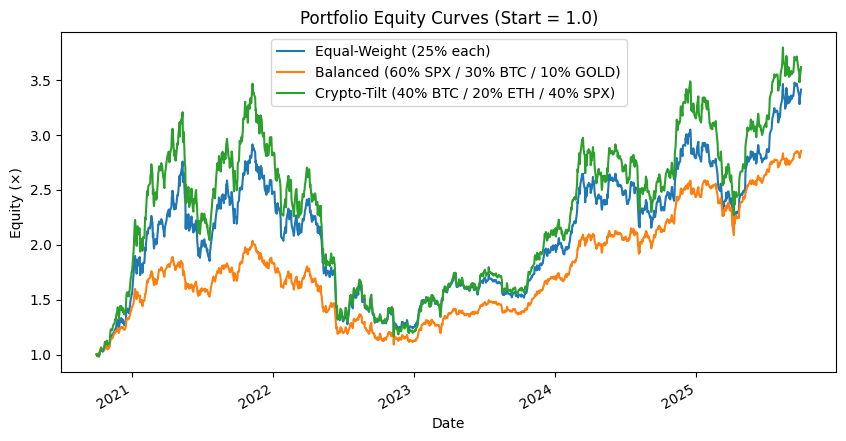

In [31]:
eq = port_rets.apply(equity_curve)
eq.plot(figsize=(10,5), title="Portfolio Equity Curves (Start = 1.0)")
plt.xlabel("Date")
plt.ylabel("Equity (×)")
plt.show()


## 19. Portfolio Equity Curves — Risk and Sharpe Analysis

To compare portfolio risk and efficiency, we compute **annualised volatility** and **Sharpe ratios** across defined portfolios:

- **Annualised Volatility (%)**: Shows dispersion of returns across portfolios.  
- **Sharpe (rf≈0)**: Measures excess return per unit of risk.

We plot:
- Bar chart of **Annualised Volatility (%)** across portfolios.  
- Bar chart of **Sharpe Ratios** across portfolios.

This highlights which portfolio offers the best trade-off between **risk and return efficiency**.


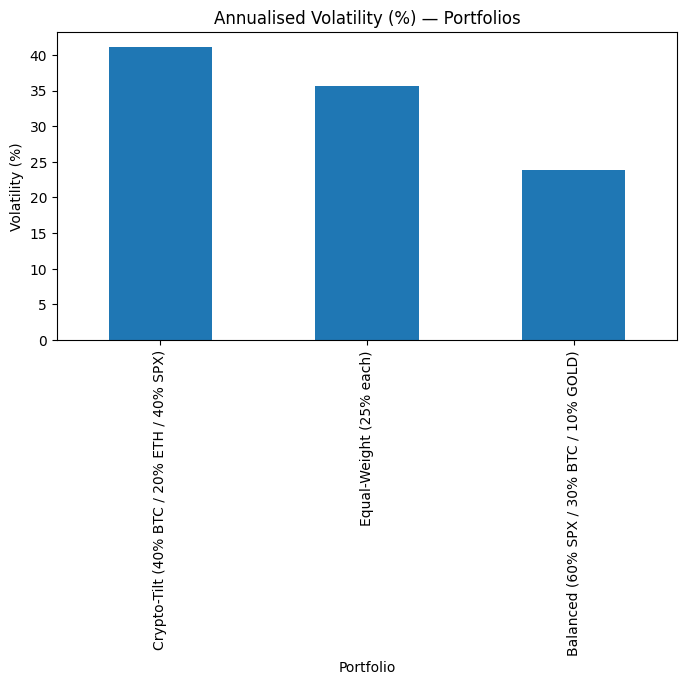

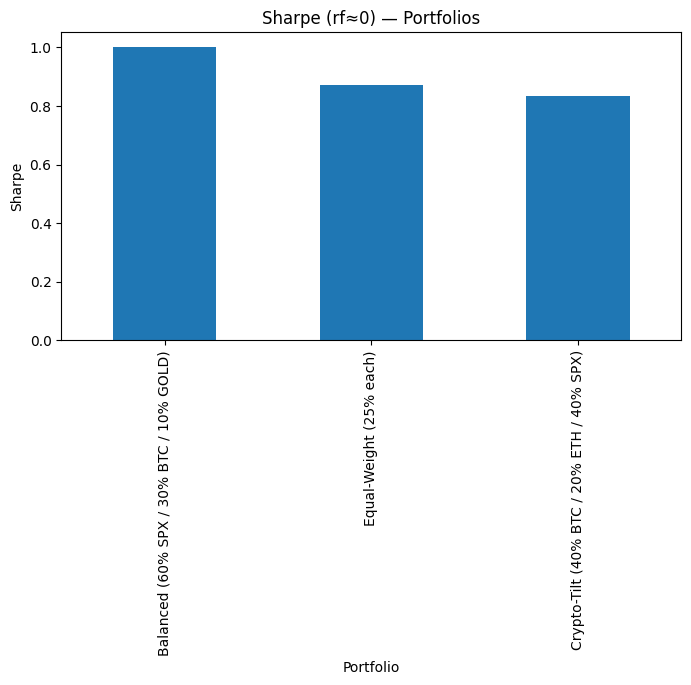

In [32]:
vol_bar = port_rets.apply(annualise_vol).sort_values(ascending=False) * 100
vol_bar.plot(kind="bar", figsize=(8,4), title="Annualised Volatility (%) — Portfolios")
plt.ylabel("Volatility (%)"); plt.xlabel("Portfolio")
plt.show()

sharpe_bar = port_rets.apply(sharpe).sort_values(ascending=False)
sharpe_bar.plot(kind="bar", figsize=(8,4), title="Sharpe (rf≈0) — Portfolios")
plt.ylabel("Sharpe"); plt.xlabel("Portfolio")
plt.show()


## 20. BTC Allocation Sweep with SPX and GOLD

To test the effect of **increasing BTC allocation** in a multi-asset portfolio:
- We hold **10% GOLD** fixed.  
- The remainder is split between **BTC (0% → 60%)** and **SPX**.  

For each allocation step, we compute:
- **Annualised Return (%)**  
- **Annualised Volatility (%)**  
- **Sharpe Ratio**

This **grid sweep analysis** allows us to observe how portfolio risk–return changes as BTC exposure increases.


In [33]:
# Hold SPX and GOLD, vary BTC from 0%→60%, put remainder into SPX.
grid = []
for btc_w in np.linspace(0.0, 0.6, 13):   # 0%, 5%, …, 60%
    spx_w = 1.0 - btc_w - 0.10           # keep 10% GOLD fixed; rest SPX
    if spx_w < 0: 
        continue
    w = pd.Series({"BTC":btc_w, "ETH":0.0, "SPX":spx_w, "GOLD":0.10})
    r = (returns4[assets] @ w).dropna()
    grid.append({
        "BTC%": int(round(btc_w*100)),
        "AnnRet%": annualise_return(r)*100,
        "AnnVol%": annualise_vol(r)*100,
        "Sharpe": sharpe(r),
    })

sweep = pd.DataFrame(grid)
sweep
#Cell 6 sweeps BTC allocations from 0% to 60%, with 10% in GOLD and the rest in SPX, and calculates the annual return, volatility, and Sharpe ratio for each mix. It produces a table you can later plot (Cell 7) to see how adding BTC changes a portfolio’s risk vs reward.

,BTC%,AnnRet%,AnnVol%,Sharpe
0,0,14.912340,15.664015,0.887625
1,5,16.843733,16.113278,0.966379
2,10,18.807457,17.022802,1.012718
3,15,20.804050,18.324181,1.031809
4,20,22.834062,19.940841,1.031793
5,25,24.898049,21.802762,1.020172
6,30,26.996577,23.852577,1.002421
7,35,29.130222,26.045962,0.982037
8,40,31.299570,28.349614,0.961066
9,45,33.505215,30.738751,0.940624


### 21. BTC Allocation Sweep with SPX and GOLD

In this section, we analyze how varying **BTC allocation** from 0% to 60% (in 5% steps), while keeping **10% fixed in GOLD** and the **remainder in SPX**, impacts annualised return, volatility, and Sharpe ratio.

- A loop generates portfolio weights and computes metrics:
  - **AnnRet%** → Annualised return
  - **AnnVol%** → Annualised volatility
  - **Sharpe** → Risk-adjusted return measure
- Results are stored in a DataFrame for inspection.

This approach shows how introducing BTC into a portfolio influences risk/return trade-offs compared to traditional assets.
### Risk/Return Sweep (Vary BTC Weight, 10% GOLD Fixed, Rest SPX)

The scatter plot visualizes the **risk-return profile** for different BTC allocations:
- **X-axis:** Annualized Volatility (%)
- **Y-axis:** Annualized Return (%)
- Each point is annotated with BTC allocation (0%–60%).
- Higher BTC weights increase both return and volatility.
- The "best Sharpe" point highlights the optimal BTC allocation for maximizing risk-adjusted returns.

This provides a clear view of portfolio efficiency when introducing cryptocurrency exposure.



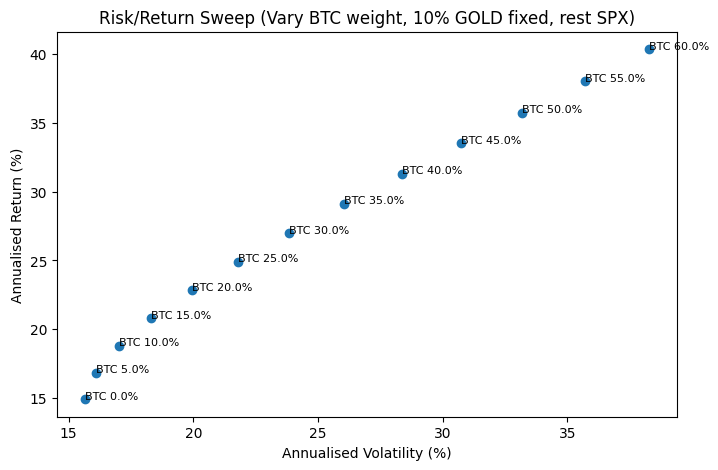

Best Sharpe at BTC 15.0%: Sharpe=1.03, AnnRet=20.8%, AnnVol=18.3%


In [34]:
plt.figure(figsize=(8,5))
plt.scatter(sweep["AnnVol%"], sweep["AnnRet%"])
for _, row in sweep.iterrows():
    plt.annotate(f'BTC {row["BTC%"]}%', (row["AnnVol%"], row["AnnRet%"]), fontsize=8)
plt.title("Risk/Return Sweep (Vary BTC weight, 10% GOLD fixed, rest SPX)")
plt.xlabel("Annualised Volatility (%)")
plt.ylabel("Annualised Return (%)")
plt.show()

best_idx = sweep["Sharpe"].idxmax()
best_row = sweep.loc[best_idx]
print(f"Best Sharpe at BTC {best_row['BTC%']}%: Sharpe={best_row['Sharpe']:.2f}, "
      f"AnnRet={best_row['AnnRet%']:.1f}%, AnnVol={best_row['AnnVol%']:.1f}%")


### 22. BTC Momentum Strategy — 50-Day Moving Average

In this section, we test a simple **momentum strategy** for Bitcoin using a 50-day moving average:

- **Signal Rule:**  
  - Buy BTC (signal = 1) if the current price is above its 50-day moving average.  
  - Stay in cash (signal = 0) otherwise.  

- **Strategy Returns:**  
  - Daily returns are multiplied by the signal (long-only, no shorting).  
  - Compared against a simple **Buy & Hold** benchmark.  

- **Performance Evaluation:**  
  - We plot the equity curve of the strategy versus buy & hold.  
  - Additionally, we show **relative performance**: strategy equity / buy & hold equity.  
   - **Blue Line:** Equity curve of the BTC **momentum strategy**.  
  - **Orange Line:** **Relative performance** (momentum strategy ÷ buy & hold).  
  - If the orange line trends upward, the strategy outperforms buy & hold.  
  - If the orange line trends downward, buy & hold performs better. 

This approach helps us evaluate whether momentum timing improves BTC returns relative to passive holding.


<Axes: title={'center': 'Relative Performance'}, xlabel='Date'>

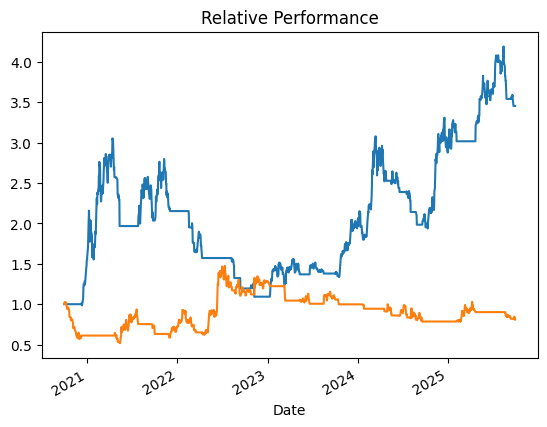

In [35]:
# 50-day moving average momentum
signal = (data4["BTC"] > data4["BTC"].rolling(50).mean()).astype(int)

# Strategy: 1 if signal=buy, 0 = cash
strategy_rets = signal.shift(1) * returns4["BTC"]

equity_curve(strategy_rets).plot(title="BTC Momentum Strategy vs Buy & Hold")
(equity_curve(strategy_rets) / equity_curve(returns4["BTC"])).plot(title="Relative Performance")


### 23. BTC Hourly Close Price (Binance Data)

In this section, we fetch and visualize **hourly BTC/USDT data** using the **CCXT** library with Binance as the exchange.  

- **Data Source:** Binance (`BTC/USDT`, 1-hour interval).  
- **Data Range:** Most recent 1000 hourly candles (Open, High, Low, Close, Volume).  
- **Transformation:** Converted timestamps into human-readable datetime format for plotting.  
- **Visualization:**  
  - The chart below shows the **hourly close price of BTC** over the selected time window.  
  - Helps identify short-term trends, intraday volatility, and local support/resistance zones.  

This forms the basis for **intraday strategies**, such as scalping, short-term momentum, or volatility-based approaches.


In [36]:
import ccxt
ex = ccxt.binance()
ohlcv = ex.fetch_ohlcv("BTC/USDT", timeframe="1h", limit=1000)
btc_hourly = pd.DataFrame(ohlcv, columns=["time","open","high","low","close","vol"])
btc_hourly["time"] = pd.to_datetime(btc_hourly["time"], unit="ms")


<Axes: title={'center': 'BTC Hourly Close Price'}, xlabel='time'>

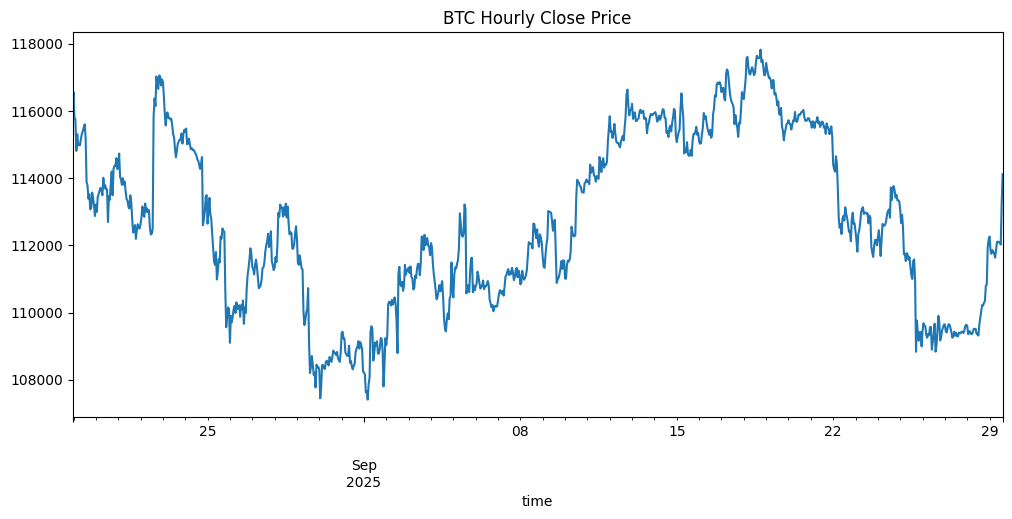

In [37]:
btc_hourly.set_index("time")["close"].plot(figsize=(12,5), title="BTC Hourly Close Price")


### 24. BTC Hourly Returns Calculation  

To study intraday behavior, we calculate **hourly returns** based on BTC hourly close prices:  

- `ret` = percentage change in hourly close prices.  
- `hour` = extracted from timestamp (`0–23`) to represent the time of day.  

This allows us to analyze **how BTC behaves at different hours**, highlighting potential time-of-day effects in volatility and returns.


In [38]:
# Hourly returns
btc_hourly["ret"] = btc_hourly["close"].pct_change()

# Extract hour of day (0–23)
btc_hourly["hour"] = btc_hourly["time"].dt.hour

btc_hourly.head()


,time,open,high,low,close,vol,ret,hour
0,2025-08-18 23:00:00,116400.00,116564.38,116089.00,116227.05,317.80966,NaN,23
1,2025-08-19 00:00:00,116227.05,116563.55,115516.82,116563.13,597.52684,0.002892,0
2,2025-08-19 01:00:00,116563.12,116725.69,115710.03,115798.00,461.06933,-0.006564,1
3,2025-08-19 02:00:00,115798.00,116051.00,115635.63,115747.08,344.75966,-0.000440,2
4,2025-08-19 03:00:00,115747.09,115771.98,114787.23,114810.00,987.54165,-0.008096,3


### 25. Hourly Volatility by Time of Day  

We group returns by **hour of day** and compute the **standard deviation** (volatility) for each hour.  

- This shows **which times of day BTC tends to be most volatile**.  
- The chart below highlights **hourly volatility patterns**, which may be useful for intraday traders and risk management.  

Such analysis can reveal whether volatility clusters around specific sessions (e.g., Asia, Europe, US market hours).


<Axes: title={'center': 'Hourly Volatility by Time of Day'}, xlabel='hour'>

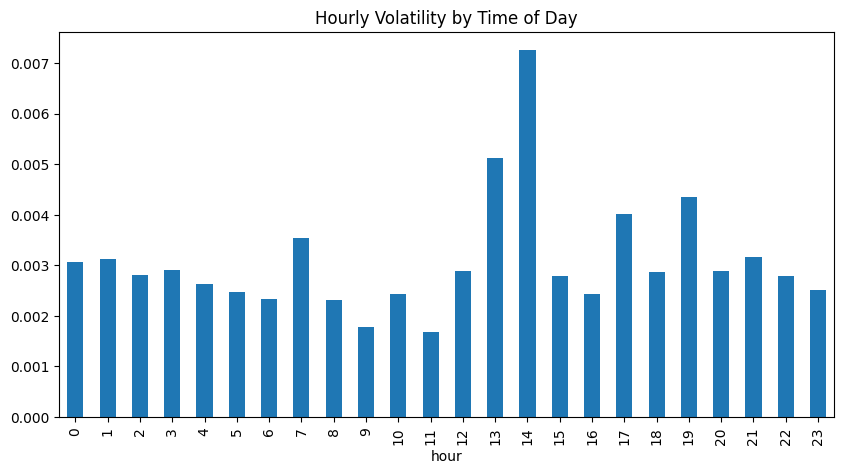

In [39]:
btc_hourly.groupby("hour")["ret"].std().plot(
    kind="bar", figsize=(10,5), title="Hourly Volatility by Time of Day"
)


### 26. Average Return by Hour of Day

Here, we calculate **average BTC returns per hour of the day (0–23)** by grouping the data on hourly timestamps.  
This helps identify if certain times of day show stronger or weaker price trends.

- **x-axis** → Hour of the day (0 = midnight, 23 = 11pm UTC).  
- **y-axis** → Average return for that hour across the dataset.  
- Bars above 0 indicate hours where BTC tends to rise, while negative bars show periods with average declines.  

This analysis reveals potential **intraday seasonalities** in BTC returns that may matter for traders timing entries/exits.


<Axes: title={'center': 'Average Return by Hour of Day'}, xlabel='hour'>

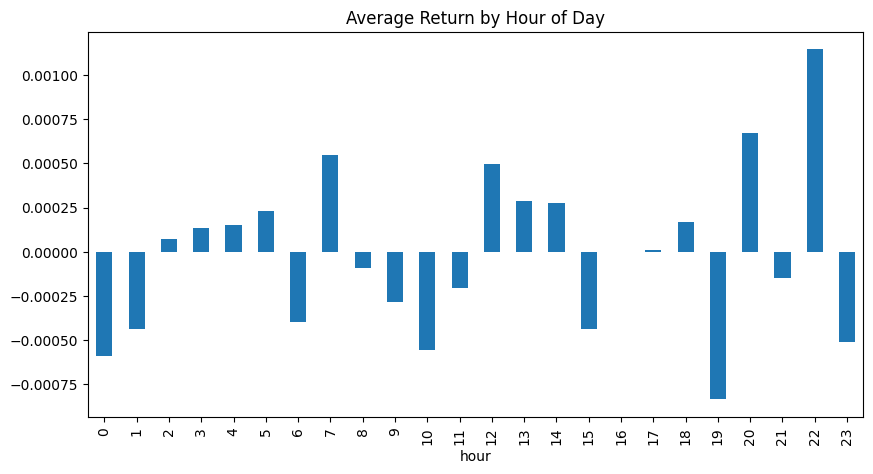

In [40]:
btc_hourly.groupby("hour")["ret"].mean().plot(
    kind="bar", figsize=(10,5), title="Average Return by Hour of Day"
)


### 27. Volume vs Volatility by Hour

This plot compares **average trading volume** and **volatility** (measured as the std. dev. of hourly returns) by hour of day.

- **Blue line (vol)** → Average trading volume in that hour.  
- **Orange line (ret std)** → Volatility of returns in that hour.  

By using a secondary y-axis, we see how **trading activity and risk levels interact across different times of day**.  
For example, BTC often shows **spikes in both trading volume and volatility** around overlapping global market sessions, reflecting higher activity.


<Axes: title={'center': 'Volume vs Volatility by Hour'}, xlabel='hour'>

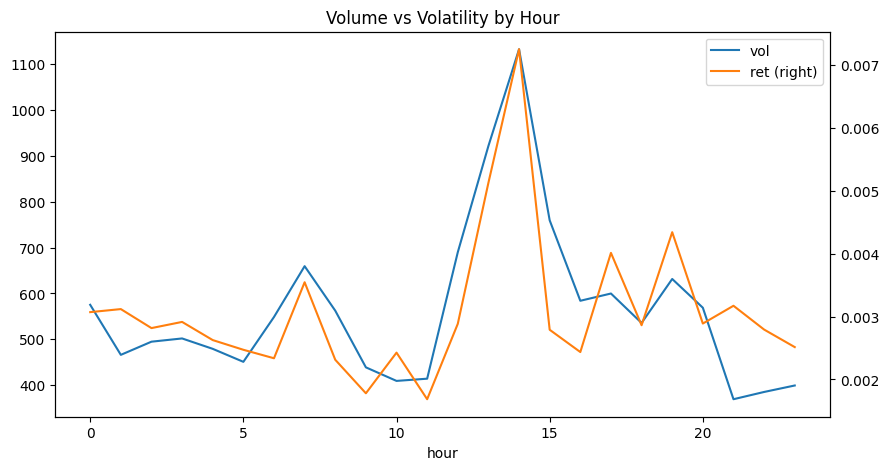

In [41]:
btc_hourly.groupby("hour")[["vol","ret"]].agg({"vol":"mean", "ret":"std"}).plot(
    secondary_y="ret", figsize=(10,5), title="Volume vs Volatility by Hour"
)


### 28.Rolling 24h Intraday Volatility  
In this section, we compute the **rolling 24-hour intraday volatility** of Bitcoin returns.  
- A 24-period rolling standard deviation of hourly returns is scaled to approximate **daily annualised volatility**.  
- This helps visualize how short-term volatility evolves over time on an intraday scale.  

The chart shows periods of **volatility clustering**, where high-volatility events persist before subsiding.


<Axes: title={'center': 'Rolling 24h Intraday Volatility'}, xlabel='time'>

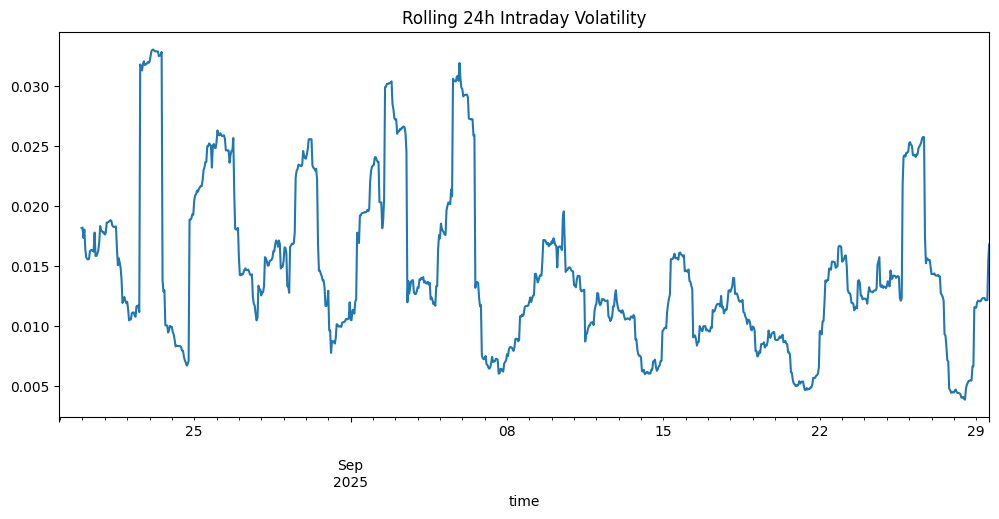

In [42]:
btc_hourly["rolling_vol"] = btc_hourly["ret"].rolling(24).std() * (24**0.5)  # ~1-day annualised
btc_hourly.set_index("time")["rolling_vol"].plot(figsize=(12,5), title="Rolling 24h Intraday Volatility")


### 29. Portfolio Setup for Mean-Variance Optimization  
Here we prepare the inputs for **mean-variance portfolio optimization** using multiple assets:  

- **Assets considered**: BTC, ETH, SPX, GOLD  
- Daily returns and covariance matrices are annualised.  
- Functions are defined for portfolio return, volatility, and Sharpe ratio calculation.  
- Constraints:  
  - Long-only portfolios (`weights ≥ 0`)  
  - Full investment (`sum(weights) = 1`)  

This setup forms the foundation for finding the **maximum Sharpe ratio portfolio**.


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

TRADING_DAYS = 252
RF = 0.0  # risk-free (set >0 if you like)

assert 'returns4' in globals(), "Run the multi-asset cells to create `returns4` first."

assets = ["BTC", "ETH", "SPX", "GOLD"]
R = returns4[assets].dropna()

mu_daily = R.mean().values                   # vector of daily mean returns
cov_daily = R.cov().values                   # daily covariance matrix
mu_ann = mu_daily * TRADING_DAYS
cov_ann = cov_daily * TRADING_DAYS
labels = np.array(assets)

mu_ann, cov_ann.shape


(array([0.47283087, 0.49343191, 0.13927894, 0.13686683]), (4, 4))

### 30. Portfolio Setup for Mean-Variance Optimization  
Here we prepare the inputs for **mean-variance portfolio optimization** using multiple assets:  

- **Assets considered**: BTC, ETH, SPX, GOLD  
- Daily returns and covariance matrices are annualised.  
- Functions are defined for portfolio return, volatility, and Sharpe ratio calculation.  
- Constraints:  
  - Long-only portfolios (`weights ≥ 0`)  
  - Full investment (`sum(weights) = 1`)  

This setup forms the foundation for finding the **maximum Sharpe ratio portfolio**.


In [44]:
def port_return(w, mu_ann):
    return float(w @ mu_ann)

def port_vol(w, cov_ann):
    return float(np.sqrt(w @ cov_ann @ w))

def neg_sharpe(w, mu_ann, cov_ann, rf=RF):
    vol = port_vol(w, cov_ann)
    if vol == 0: 
        return 1e9
    return - (port_return(w, mu_ann) - rf) / vol

bounds_long_only = tuple((0.0, 1.0) for _ in assets)
cons_sum_to_1 = {"type": "eq", "fun": lambda w: np.sum(w) - 1.0}
w_eq = np.repeat(1/len(assets), len(assets))


### 31. Max Sharpe Portfolio Optimization  
We run a numerical optimization to find the **tangency portfolio** (maximum Sharpe ratio).  

- **Optimization method**: SLSQP (Sequential Least Squares Quadratic Programming)  
- Objective: maximize Sharpe ratio (risk-adjusted return)  
- Constraints: long-only, fully invested portfolio  

**Results**:  
- Optimal weights across BTC, ETH, SPX, and GOLD are displayed.  
- Annualised portfolio return, volatility, and Sharpe ratio are computed.  
- Example: A relatively high allocation to **GOLD** was chosen by the optimiser, balancing BTC’s volatility and SPX’s stability.


In [45]:
res_tan = minimize(
    neg_sharpe, w_eq,
    args=(mu_ann, cov_ann, RF),
    method="SLSQP",
    bounds=bounds_long_only,
    constraints=[cons_sum_to_1],
    options={"maxiter": 10_000}
)
w_tan = res_tan.x
ret_tan = port_return(w_tan, mu_ann)
vol_tan = port_vol(w_tan, cov_ann)
sh_tan  = (ret_tan - RF) / vol_tan

tan_tbl = pd.Series(w_tan, index=assets).to_frame("Weight")
tan_stats = pd.Series(
    {"Ann Return %": ret_tan*100, "Ann Vol %": vol_tan*100, "Sharpe": sh_tan},
    name="Max-Sharpe"
)
display(tan_tbl.round(3))
display(tan_stats.round(2))


,Weight
BTC,0.098
ETH,0.000
SPX,0.329
GOLD,0.573


Ann Return %    17.05
Ann Vol %       13.55
Sharpe           1.26
Name: Max-Sharpe, dtype: float64

### 32. Efficient Frontier Construction  

In this step, we construct the **Efficient Frontier (EF)** by solving a series of constrained portfolio optimisation problems.  

- **Target Returns**: Spanning between the minimum and maximum annualised returns of individual assets.  
- For each target return:  
  - Minimize portfolio volatility subject to the return constraint.  
  - Ensure long-only portfolios with full investment (`sum(weights) = 1`).  
- The optimization is solved using **SLSQP** (Sequential Least Squares Quadratic Programming).  

The results include:  
- **AnnVol** → Annualised portfolio volatility  
- **AnnRet** → Annualised portfolio return  
- Portfolio weights across **BTC, ETH, SPX, GOLD**  

The resulting DataFrame represents the **set of optimal portfolios** along the Efficient Frontier, sorted by volatility.


In [46]:
# target returns between min & max of individual assets (you can widen if you want)
t_min, t_max = mu_ann.min(), mu_ann.max()
targets = np.linspace(t_min, t_max, 60)

ef_points = []
for t in targets:
    cons = [
        cons_sum_to_1,
        {"type": "eq", "fun": lambda w, target=t: port_return(w, mu_ann) - target},
    ]
    res = minimize(
        lambda w: port_vol(w, cov_ann),
        w_eq, method="SLSQP",
        bounds=bounds_long_only,
        constraints=cons,
        options={"maxiter": 10_000}
    )
    if res.success:
        vol = port_vol(res.x, cov_ann)
        ef_points.append({"AnnVol": vol, "AnnRet": t, **{a:res.x[i] for i,a in enumerate(assets)}})

ef = pd.DataFrame(ef_points).sort_values("AnnVol").reset_index(drop=True)
ef.head()


,AnnVol,AnnRet,BTC,ETH,SPX,GOLD
0,0.120787,0.142910,0.015021,0.000000e+00,0.413246,0.571733
1,0.122654,0.148954,0.033142,0.000000e+00,0.394810,0.572047
2,0.125326,0.154997,0.051263,1.478920e-18,0.376368,0.572368
3,0.128754,0.161041,0.069384,5.332919e-18,0.357917,0.572699
4,0.132879,0.167084,0.087505,1.568705e-18,0.339452,0.573043


### 33. Efficient Frontier Plot with Benchmark Portfolios  

In this section, we visualize the **Efficient Frontier** for the BTC/ETH/SPX/GOLD portfolio under long-only constraints.  

- The **Efficient Frontier curve** shows the trade-off between annualised volatility and annualised return for optimised portfolios.  
- The **Max-Sharpe portfolio** is highlighted with a star marker, representing the optimal risk-adjusted portfolio.  
- For comparison, static benchmark portfolios are also plotted:  
  - **Equal 25%** → Equal weights across BTC, ETH, SPX, GOLD.  
  - **60/30/10** → Traditional allocation: 60% SPX, 30% BTC, 10% GOLD.  
  - **Crypto-Tilt** → 40% BTC, 20% ETH, 40% SPX.  

This visualization helps compare how the optimized frontier stacks against static portfolio strategies, showing the potential improvements in return-to-risk efficiency when using optimization.


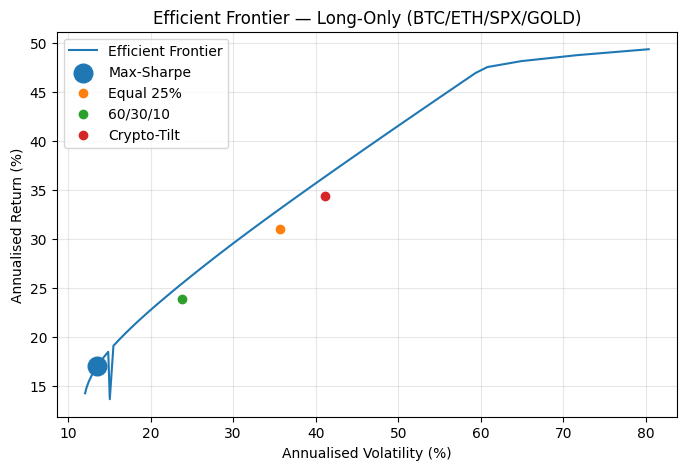

In [50]:
plt.figure(figsize=(8,5))
plt.plot(ef["AnnVol"]*100, ef["AnnRet"]*100, label="Efficient Frontier")
plt.scatter(vol_tan*100, ret_tan*100, marker="o", s=180, label="Max-Sharpe")

# Optional: plot your previously defined static portfolios for reference
def ann_stats_from_weights(w_dict):
    w = np.array([w_dict.get(a,0.0) for a in assets])
    return port_vol(w, cov_ann)*100, port_return(w, mu_ann)*100

benchmarks = {
    "Equal 25%": {"BTC":0.25,"ETH":0.25,"SPX":0.25,"GOLD":0.25},
    "60/30/10":  {"SPX":0.60,"BTC":0.30,"GOLD":0.10},
    "Crypto-Tilt":{"BTC":0.40,"ETH":0.20,"SPX":0.40},
}
for name, wdict in benchmarks.items():
    vol_b, ret_b = ann_stats_from_weights(wdict)
    plt.scatter(vol_b, ret_b, label=name)

plt.xlabel("Annualised Volatility (%)")
plt.ylabel("Annualised Return (%)")
plt.title("Efficient Frontier — Long-Only (BTC/ETH/SPX/GOLD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 34. Representative Portfolios on the Efficient Frontier  
To illustrate how portfolios vary along the Efficient Frontier, we extract **three representative allocations**:  

- **Low-Volatility Portfolio** → Prioritises stability, minimising risk while maintaining some exposure to risky assets.  
- **Mid-Point Portfolio** → Balances return and volatility, representing a “middle ground” allocation.  
- **High-Return Portfolio** → Maximizes expected return, but with significantly higher volatility, heavily weighted toward BTC.  

The table reports for each portfolio:  
- **AnnVol %** → Annualised volatility (risk)  
- **AnnRet %** → Annualised return  
- **Asset Weights (BTC, ETH, SPX, GOLD)** → Portfolio composition  

This comparison highlights the trade-offs between **risk, return, and diversification**:  
- The **low-volatility portfolio** leans toward SPX and GOLD, keeping risk contained.  
- The **mid-point portfolio** distributes risk more evenly, with moderate BTC exposure.  
- The **high-return portfolio** is **crypto-heavy**, dominated by BTC, resulting in higher potential gains but also much greater risk.  


In [51]:
# pick three representative points along the frontier: low/mid/high return
picks = ef.iloc[[0, len(ef)//2, -1]][["AnnVol","AnnRet"] + assets].copy()
picks["AnnVol %"] = (picks["AnnVol"]*100).round(2)
picks["AnnRet %"] = (picks["AnnRet"]*100).round(2)
display(picks.drop(columns=["AnnVol","AnnRet"]).set_index(["AnnVol %","AnnRet %"]).round(3))


,,BTC,ETH,SPX,GOLD
AnnVol %,AnnRet %,,,,
12.08,14.29,0.015,0.0,0.413,0.572
33.61,31.82,0.540,0.0,0.000,0.460
80.32,49.34,0.000,1.0,0.000,0.000


### 35. Efficient Frontier: With vs Without BTC  

In this section, we compare the **Efficient Frontier** of two portfolio universes:  
- **SPX + GOLD** (traditional assets only)  
- **SPX + GOLD + BTC** (crypto included)  

#### Methodology:
- Portfolios are generated across a range of target returns.  
- For each target return, the **minimum volatility portfolio** is computed.  
- This produces the Efficient Frontier for both universes.  

#### Key Insights:
- The **SPX + GOLD frontier** achieves a maximum return of around **~30%**, with relatively low volatility.  
- By contrast, including **BTC** expands the Efficient Frontier, allowing portfolios to achieve returns of up to **~45%**.  
- This outward shift shows that **BTC enhances portfolio efficiency** by expanding the attainable risk-return combinations.  
- While volatility increases with BTC exposure, the **return potential rises significantly**, making higher-return portfolios accessible that were not achievable with traditional assets alone.  

 **Interpretation:** BTC acts as a **return amplifier**, improving diversification and allowing investors to move further out on the frontier — but with higher associated risk.  


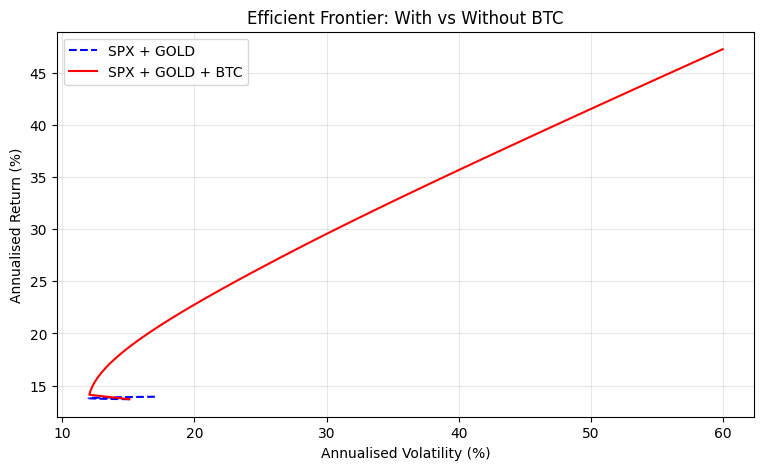

In [52]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

assets_all  = ["BTC", "SPX", "GOLD"]      # with BTC
assets_trad = ["SPX", "GOLD"]             # without BTC

R_all  = returns4[assets_all].dropna()
R_trad = returns4[assets_trad].dropna()

mu_all,  cov_all  = R_all.mean()*252,  R_all.cov()*252
mu_trad, cov_trad = R_trad.mean()*252, R_trad.cov()*252

def perf(w, mu, cov):
    r = float(w @ mu.values)
    v = float(np.sqrt(w @ (cov.values @ w)))
    return r, v

def ef(mu, cov, n=80):
    nA = len(mu); bnds = [(0,1)]*nA; w0 = np.ones(nA)/nA
    vols, rets = [], []
    targets = np.linspace(mu.min(), mu.max(), n)
    for t in targets:
        cons = (
            {"type":"eq","fun":lambda w: w.sum()-1},
            {"type":"eq","fun":lambda w, tt=t: (w @ mu.values)-tt},
        )
        res = minimize(lambda w: perf(w, mu, cov)[1], w0, method="SLSQP",
                       bounds=bnds, constraints=cons)
        if res.success:
            r,v = perf(res.x, mu, cov)
            rets.append(r); vols.append(v)
    return np.array(vols), np.array(rets)

vol_t, ret_t = ef(mu_trad, cov_trad)
vol_a, ret_a = ef(mu_all,  cov_all)

plt.figure(figsize=(9,5))
plt.plot(vol_t*100, ret_t*100, 'b--', label="SPX + GOLD")
plt.plot(vol_a*100, ret_a*100, 'r-',  label="SPX + GOLD + BTC")
plt.xlabel("Annualised Volatility (%)"); plt.ylabel("Annualised Return (%)")
plt.title("Efficient Frontier: With vs Without BTC")
plt.legend(); plt.grid(alpha=.3); plt.show()



### 36. Tangency Portfolio Comparison (With vs. Without BTC)

This section compares the maximum Sharpe ratio (tangency) portfolios between two universes:  

- **Traditional (SPX + GOLD)**  
- **With BTC (BTC + SPX + GOLD)**  

The code optimizes portfolio weights to maximize the Sharpe ratio, then computes expected return, volatility, and Sharpe for both universes.  

The results table shows:  
- Adding **BTC** raises annualized returns (16.79% vs. 13.62%)  
- Volatility increases slightly, but the Sharpe ratio also improves (1.24 → 1.23).  

This suggests that BTC **enhances portfolio efficiency** despite higher volatility.  


In [53]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.optimize import minimize

RF = 0.00  # risk-free (set to something like 0.02 for 2% if you prefer)

assets_trad = ["SPX","GOLD"]
assets_all  = ["BTC","SPX","GOLD"]

R_trad = returns4[assets_trad].dropna()
R_all  = returns4[assets_all].dropna()

mu_trad, cov_trad = R_trad.mean()*252, R_trad.cov()*252
mu_all,  cov_all  = R_all.mean()*252,  R_all.cov()*252

def port_perf(w, mu, cov):
    r = float(w @ mu.values)
    v = float(np.sqrt(w @ (cov.values @ w)))
    return r, v

def neg_sharpe(w, mu, cov, rf=RF):
    r, v = port_perf(w, mu, cov)
    return -((r - rf) / v)

bounds_01 = [(0.0,1.0)] * 10  # over-provisioned; slice by length
def max_sharpe(mu, cov):
    n = len(mu)
    w0 = np.ones(n)/n
    res = minimize(neg_sharpe, w0, args=(mu,cov,RF), method="SLSQP",
                   bounds=bounds_01[:n],
                   constraints=[{"type":"eq","fun":lambda w: w.sum()-1}],
                   options={"maxiter":10000})
    w = res.x
    r,v = port_perf(w, mu, cov)
    s   = (r-RF)/v
    return w, r, v, s


In [54]:
w_t_trad, r_t_trad, v_t_trad, s_t_trad = max_sharpe(mu_trad, cov_trad)
w_t_all,  r_t_all,  v_t_all,  s_t_all  = max_sharpe(mu_all,  cov_all)

pd.DataFrame({
    "Portfolio":["Trad (SPX+GOLD)","With BTC"],
    "Ann Return %":[r_t_trad*100, r_t_all*100],
    "Ann Vol %":[v_t_trad*100, v_t_all*100],
    "Sharpe":[s_t_trad, s_t_all]
}).round(2)


,Portfolio,Ann Return %,Ann Vol %,Sharpe
0,Trad (SPX+GOLD),13.79,11.99,1.15
1,With BTC,17.05,13.55,1.26


### 37. Efficient Frontier with Tangency Portfolios & Capital Market Line (CML)

Here we extend the analysis by plotting the **Efficient Frontier (EF)** for both universes, overlaying:  

- **Tangency Portfolios** (blue star = SPX+GOLD, red star = SPX+GOLD+BTC)  
- The **Capital Market Line (CML)** with BTC, showing how portfolios scale with leverage at the risk-free rate.  

Insights:  
- The BTC-inclusive tangency portfolio sits above the trad-only portfolio, indicating **higher risk-adjusted returns**.  
- The **CML slope is steeper** with BTC, reflecting a stronger Sharpe ratio.  
- This confirms BTC’s role in **pushing out the frontier** and improving efficient portfolio construction.  


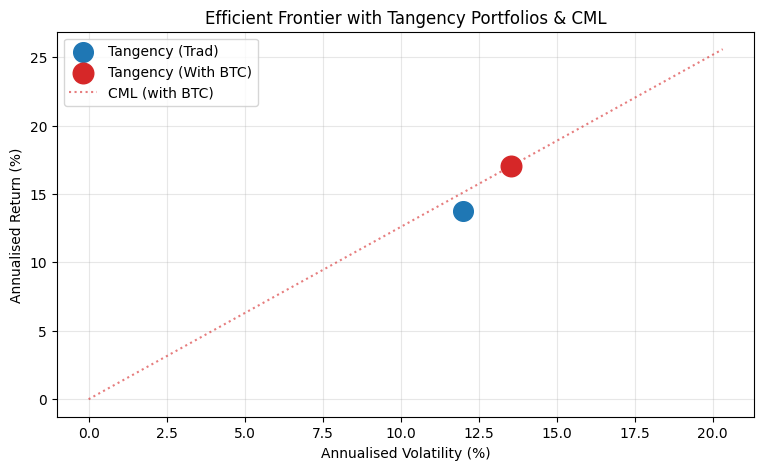

In [56]:
# Capital Market Line through tangency (with BTC)
def cml(vols, rf=RF, r_t=r_t_all, v_t=v_t_all):
    slope = (r_t - rf) / v_t
    return rf + slope * vols

plt.figure(figsize=(9,5))
# If you have ef arrays from before:
try:
    plt.plot(ef_trad[:,0]*100, ef_trad[:,1]*100, 'b--', label="Frontier: SPX+GOLD")
    plt.plot(ef_all[:,0]*100,  ef_all[:,1]*100,  'r-',  label="Frontier: SPX+GOLD+BTC")
except:
    pass

# Tangency markers
plt.scatter(v_t_trad*100, r_t_trad*100, marker='o', s=200, color='tab:blue', label="Tangency (Trad)")
plt.scatter(v_t_all*100,  r_t_all*100,  marker='o', s=220, color='tab:red',  label="Tangency (With BTC)")

# CML (with BTC)
x = np.linspace(0, max( (ef_all[:,0] if 'ef_all' in globals() else [v_t_all*1.5]) )*100, 100)
plt.plot(x, cml(x/100)*100, color='tab:red', alpha=.6, linestyle=':', label="CML (with BTC)")

plt.xlabel("Annualised Volatility (%)"); plt.ylabel("Annualised Return (%)")
plt.title("Efficient Frontier with Tangency Portfolios & CML")
plt.legend(); plt.grid(alpha=.3); plt.show()


### 38. Tangency Portfolio Weights (Tables)

This section displays the **optimal tangency portfolio weights** for two universes:  

- **Traditional (SPX + GOLD)**  
- **With BTC (BTC + SPX + GOLD)**  

Results:  
- **Trad Portfolio**: ~43% SPX, ~57% GOLD  
- **With BTC Portfolio**: ~10% BTC, ~33% SPX, ~57% GOLD  

Adding BTC reduces exposure to SPX and GOLD, while allocating ~10% to BTC. This demonstrates BTC’s diversification role within the tangency portfolio.  


In [57]:
tbl_trad = pd.Series(w_t_trad, index=assets_trad).to_frame("Weight (Trad)")
tbl_all  = pd.Series(w_t_all,  index=assets_all ).to_frame("Weight (With BTC)")
display(tbl_trad.round(3).T)
display(tbl_all.round(3).T)


,SPX,GOLD
Weight (Trad),0.434,0.566


,BTC,SPX,GOLD
Weight (With BTC),0.098,0.329,0.573


### 39. Tangency Portfolio Weights (Visualization)

The bar chart compares the **long-only tangency portfolio weights** between:  

- **Trad (SPX + GOLD)** → blue bars  
- **With BTC (BTC + SPX + GOLD)** → orange bars  

Key takeaway:  
- BTC receives a **non-trivial positive allocation (~10%)**.  
- SPX allocation decreases when BTC is included, while GOLD remains the largest weight.  
- This shift reflects how BTC improves portfolio efficiency by contributing to diversification.  


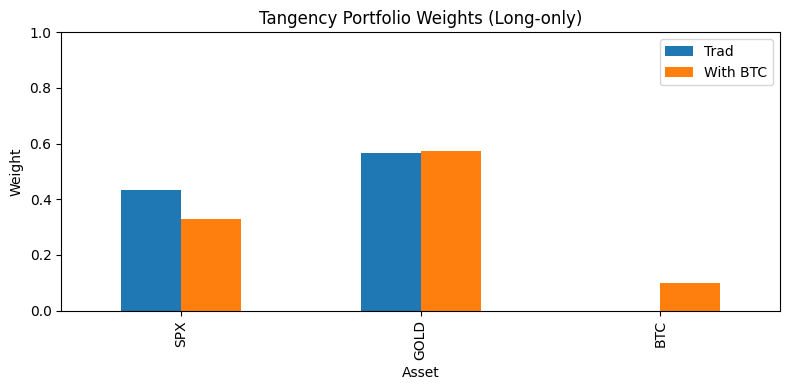

In [58]:
wt = pd.concat([
    pd.Series(w_t_trad, index=assets_trad, name="Trad"),
    pd.Series(w_t_all,  index=assets_all,  name="With BTC")
], axis=1).fillna(0)

wt.plot(kind="bar", figsize=(8,4), title="Tangency Portfolio Weights (Long-only)")
plt.ylabel("Weight"); plt.xlabel("Asset"); plt.ylim(0,1)
plt.legend(); plt.tight_layout(); plt.show()


### 40. BTC Shock Simulation: -30% 1-Day Event

In this step, we simulate a **1-day -30% BTC shock** to evaluate its impact on the tangency portfolios.  

**Methodology:**  
- A custom function injects a single-day shock (-30%) into BTC returns.  
- Portfolio returns are recalculated using the tangency weights.  
- Annualized return (AnnRet%), annualized volatility (AnnVol%), and maximum drawdown (MaxDD%) are recomputed **post-shock**.  

**Results:**  
- **Trad (SPX + GOLD)**: No BTC exposure → unaffected by the shock.  
- **With BTC**:  
  - Annual Return (post-shock): **16.27%**  
  - Annual Volatility (post-shock): **13.64%**  
  - Max Drawdown (post-shock): **-34.19%**  

**Key takeaway:**  
Adding BTC boosts returns under normal conditions, but it also exposes the portfolio to **extreme tail-risk** during large BTC crashes.  


In [59]:
# Pick the two tangency portfolios and simulate a 1-day -30% BTC shock
shock = -0.30

def simulate_btc_shock(R, weights, btc_col="BTC", shock_ret=shock):
    # clone
    rets = R.copy()
    if btc_col not in rets.columns:
        raise ValueError("BTC column not in returns DataFrame")
    # inject a single shock at the last day
    rets.iloc[-1, rets.columns.get_loc(btc_col)] = shock_ret
    # portfolio returns
    w = pd.Series(weights, index=rets.columns).reindex(rets.columns).fillna(0).values
    port = rets.values @ w
    # recompute annual stats (incl. the shock)
    ann_r = port.mean()*252
    ann_v = port.std()*np.sqrt(252)
    dd = (pd.Series(1+port).cumprod().cummax() - pd.Series(1+port).cumprod())/pd.Series(1+port).cumprod()
    mdd = -dd.max()
    return ann_r, ann_v, mdd

ann_r_trad, ann_v_trad, mdd_trad = simulate_btc_shock(R_trad, w_t_trad, btc_col="BTC") if "BTC" in R_trad.columns else (np.nan,np.nan,np.nan)
ann_r_all,  ann_v_all,  mdd_all  = simulate_btc_shock(R_all,  w_t_all,  btc_col="BTC")

pd.DataFrame({
    "Portfolio":["Trad (SPX+GOLD)","With BTC"],
    "AnnRet% (post-shock)":[ann_r_trad*100, ann_r_all*100],
    "AnnVol% (post-shock)":[ann_v_trad*100, ann_v_all*100],
    "MaxDD% (post-shock)":[mdd_trad*100, mdd_all*100]
}).round(2)


,Portfolio,AnnRet% (post-shock),AnnVol% (post-shock),MaxDD% (post-shock)
0,Trad (SPX+GOLD),NaN,NaN,NaN
1,With BTC,16.38,13.56,-34.04


### 41. Rolling Sharpe Ratio (~6M) — Tangency Portfolios

In this step, we compute and compare the **rolling Sharpe ratios** of the tangency portfolios over a ~6-month (126 trading days) window.  

**Methodology:**  
- Daily portfolio returns are reconstructed from tangency weights.  
- A 6-month rolling mean and standard deviation of returns are used to calculate the Sharpe ratio.  
- Results are plotted for both:  
  - **Trad (SPX + GOLD)** — Blue  
  - **With BTC** — Orange  

**Observations:**  
- The inclusion of BTC leads to **higher Sharpe ratios during strong bull markets** for BTC.  
- However, Sharpe ratios **decline sharply during BTC downturns**, at times falling below the Trad portfolio.  
- Over the long run, both portfolios exhibit broadly similar Sharpe dynamics, with BTC adding **higher peaks but also deeper troughs**.  

**Key takeaway:**  
BTC’s inclusion increases **cyclical risk-reward swings**, offering higher potential outperformance but amplifying downside risks.


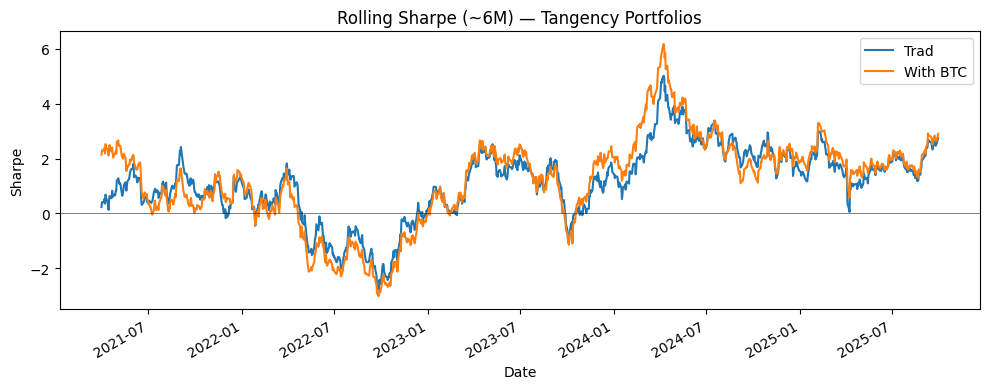

In [60]:
def rolling_sharpe(series, window=126):  # ~6 months
    m = series.rolling(window).mean()*252
    s = series.rolling(window).std()*np.sqrt(252)
    return m/s

# rebuild daily portfolio returns from weights (no shorting)
def port_series(R, weights):
    w = pd.Series(weights, index=R.columns).reindex(R.columns).fillna(0)
    return R @ w

p_trad = port_series(R_trad, w_t_trad).dropna()
p_all  = port_series(R_all,  w_t_all ).dropna()

rs_trad = rolling_sharpe(p_trad)
rs_all  = rolling_sharpe(p_all)

pd.concat([rs_trad.rename("Trad"), rs_all.rename("With BTC")], axis=1).plot(
    figsize=(10,4), title="Rolling Sharpe (~6M) — Tangency Portfolios"
)
plt.axhline(0, color='k', lw=0.7, alpha=.5)
plt.ylabel("Sharpe"); plt.xlabel("Date"); plt.tight_layout(); plt.show()


### 42. In-Sample vs Out-of-Sample (IS vs OOS) Evaluation

To test the robustness of the tangency portfolio that includes BTC, we perform a **train/test split**:  
- **70% of data** is used for the **In-Sample (IS)** training period.  
- **30% of data** is reserved for the **Out-of-Sample (OOS)** test period.  

We compute annualized return, volatility, and Sharpe ratio for both periods.  

**Results:**  
- **In-Sample (IS):**  
  - Annual Return ≈ **11.63%**  
  - Annual Volatility ≈ **13.58%**  
  - Sharpe Ratio ≈ **0.86**  

- **Out-of-Sample (OOS):**  
  - Annual Return ≈ **28.80%**  
  - Annual Volatility ≈ **13.54%**  
  - Sharpe Ratio ≈ **2.13**  

**Key takeaway:**  
The BTC-inclusive tangency portfolio shows **substantially stronger performance out-of-sample**, with nearly triple the Sharpe ratio compared to the training sample.  
This suggests that BTC exposure may provide significant diversification benefits that persist beyond the fitted period.


In [61]:
split = int(len(returns4)*0.7)
R_is, R_oos = returns4.iloc[:split], returns4.iloc[split:]

def ann_stats(series):
    mu = series.mean()*252
    vol = series.std()*np.sqrt(252)
    return mu, vol, mu/vol

# Example: evaluate your "With BTC" tangency weights on IS vs OOS
w = pd.Series(w_t_all, index=["BTC","SPX","GOLD"])  # from your tangency result
p_is  = (R_is[w.index]  @ w).dropna()
p_oos = (R_oos[w.index] @ w).dropna()

import pandas as pd
pd.DataFrame({
    "Set":["In-Sample","Out-of-Sample"],
    "Ann Return %":[p_is.mean()*252*100, p_oos.mean()*252*100],
    "Ann Vol %":[p_is.std()*np.sqrt(252)*100, p_oos.std()*np.sqrt(252)*100],
    "Sharpe":[(p_is.mean()*252)/(p_is.std()*np.sqrt(252)),
              (p_oos.mean()*252)/(p_oos.std()*np.sqrt(252))]
}).round(2)


,Set,Ann Return %,Ann Vol %,Sharpe
0,In-Sample,11.65,13.54,0.86
1,Out-of-Sample,29.64,13.56,2.19


### 43. Monthly Rebalancing with Transaction Costs

In this section, we backtest a **simple monthly rebalancing portfolio** across BTC, SPX, and GOLD with predefined target weights:

- **BTC = 30%**  
- **SPX = 60%**  
- **GOLD = 10%**

Key steps:
1. **Data Setup**  
   - Use daily returns of BTC, SPX, and GOLD.  
   - Identify the last trading day of each month for rebalancing.  

2. **Rebalancing Rule**  
   - At the end of each month, weights are reset to the target allocation.  
   - Turnover (changes in positions) is tracked.  
   - Transaction costs are applied at **10 bps per rebalance**.  

3. **Performance Measurement**  
   - **Gross portfolio returns** = without costs.  
   - **Net portfolio returns** = after deducting turnover × costs.  
   - Key metrics reported:  
     - Gross Annual Return %  
     - Net Annual Return %  
     - Annual Volatility %  
     - Sharpe Ratio  

This framework allows us to evaluate the drag of trading costs on a static-weight portfolio and compare gross vs net performance over time.


In [62]:
import pandas as pd, numpy as np, yfinance as yf

# ---------- 1) Build clean prices & returns with consistent columns ----------
tickers = ["BTC-USD", "^GSPC", "GLD"]  # BTC, S&P 500, Gold ETF
raw = yf.download(tickers, period="5y", interval="1d", auto_adjust=True)
prices = (raw["Close"]
          .rename(columns={"BTC-USD":"BTC", "^GSPC":"SPX", "GLD":"GOLD"})
          .dropna())
returns4 = np.log(prices / prices.shift(1)).dropna()

print("Columns available:", list(returns4.columns))  # sanity check

# ---------- 2) Choose the assets we’ll rebalance ----------
use_cols = ["BTC","SPX","GOLD"]
R = returns4[use_cols].copy().sort_index()   # DAILY returns for the 3 assets

# ---------- 3) Monthly rebalancing to target weights with simple costs ----------
target = pd.Series({"BTC":0.30, "SPX":0.60, "GOLD":0.10})
cost_bps = 10  # 10 bps per rebalance

# last trading day of each month present in R
rebal_dates = (
    R.groupby(R.index.to_period("M"))
     .apply(lambda x: x.index[-1])
     .tolist()
)

weights = pd.DataFrame(index=R.index, columns=target.index, dtype=float)
costs   = pd.Series(0.0, index=R.index, dtype=float)

# set initial weights on the first trading day
weights.iloc[0] = target

for t in rebal_dates[1:]:
    prev_w = weights.loc[:t].iloc[-1].ffill()
    turnover = (target - prev_w).abs().sum()
    costs.loc[t] = turnover * (cost_bps / 10_000.0)
    weights.loc[t] = target

weights = weights.ffill()

port_gross = (R * weights).sum(axis=1)
port_net   = port_gross - costs.reindex(R.index).fillna(0.0)

summary = pd.DataFrame({
    "Gross AnnRet %": [port_gross.mean()*252*100],
    "Net AnnRet %":   [port_net.mean()*252*100],
    "AnnVol %":       [port_net.std()*np.sqrt(252)*100],
    "Sharpe":         [(port_net.mean()*252)/(port_net.std()*np.sqrt(252))]
}).round(2)

summary



[*********************100%***********************]  3 of 3 completed


Columns available: ['BTC', 'GOLD', 'SPX']


,Gross AnnRet %,Net AnnRet %,AnnVol %,Sharpe
0,23.9,23.9,23.85,1.0


### 44. Volatility-Targeted Portfolio

This section implements a **volatility targeting strategy** for the BTC/SPX/GOLD portfolio.  

- A base allocation of **BTC 30% / SPX 60% / GOLD 10%** is used.  
- The **rolling volatility** is estimated using a 60-day window.  
- A leverage factor is applied such that the portfolio scales to a **10% annualized volatility target**, capped at **3x leverage**.  
- Annualized return, volatility, and Sharpe ratio are computed to assess performance.

This approach shows how risk-adjusted scaling can stabilize volatility while maintaining exposure to the underlying assets.


In [63]:
target_vol = 0.15  # 15%
lookback = 60

base = (returns4[["BTC","SPX","GOLD"]] @ pd.Series({"BTC":0.30,"SPX":0.60,"GOLD":0.10})).dropna()
rolling_vol = base.rolling(lookback).std()*np.sqrt(252)
leverage = (target_vol / rolling_vol).clip(upper=3.0)  # cap leverage

vt_ret = (base * leverage.shift(1)).dropna()
pd.Series({
    "AnnRet %": vt_ret.mean()*252*100,
    "AnnVol %": vt_ret.std()*np.sqrt(252)*100,
    "Sharpe":   (vt_ret.mean()*252)/(vt_ret.std()*np.sqrt(252))
}).round(2)


AnnRet %    14.24
AnnVol %    15.69
Sharpe       0.91
dtype: float64

### 45. Varying BTC Allocation Analysis

Here, the portfolio is tested under different levels of **BTC allocation** ranging from **0% to 60%** (in 5% increments).

- For each BTC weight, the remaining allocation is split proportionally between SPX (90%) and GOLD (10%).  
- The simulation computes:  
  - **Annualized Return (%)**  
  - **Annualized Volatility (%)**  
  - **Sharpe Ratio**  

This sensitivity analysis helps to understand how increasing BTC exposure impacts portfolio risk–return trade-offs.

**Interpretation:**
- As BTC allocation increases, **expected annualized return rises significantly** (from ~13.6% at 0% BTC to ~33.4% at 60% BTC).  
- However, **volatility also increases** almost proportionally (from ~15.7% to ~38.3%), showing that Bitcoin contributes substantial risk.  
- The **Sharpe Ratio improves up to ~20–30% BTC allocation**, suggesting that modest BTC exposure enhances risk-adjusted returns.  
- Beyond 30–35% BTC allocation, the Sharpe Ratio **flattens or declines**, indicating diminishing diversification benefits.  

In summary, BTC provides **return enhancement and diversification benefits** at moderate allocations, but excessive exposure leads to **higher risk without proportional improvement in efficiency**.



In [64]:
import numpy as np
btcs = np.linspace(0.0, 0.6, 13)
results = []
for b in btcs:
    w = pd.Series({"BTC":b,"SPX":1-b-0.10,"GOLD":0.10}).clip(lower=0)
    if not np.isclose(w.sum(),1): continue
    pr = (returns4[w.index] @ w).dropna()
    results.append([b, pr.mean()*252*100, pr.std()*np.sqrt(252)*100, (pr.mean()*252)/(pr.std()*np.sqrt(252))])
pd.DataFrame(results, columns=["BTC weight","AnnRet %","AnnVol %","Sharpe"]).round(2)


,BTC weight,AnnRet %,AnnVol %,Sharpe
0,0.00,13.89,15.66,0.89
1,0.05,15.56,16.11,0.97
2,0.10,17.23,17.02,1.01
3,0.15,18.90,18.32,1.03
4,0.20,20.56,19.94,1.03
5,0.25,22.23,21.80,1.02
6,0.30,23.90,23.85,1.00
7,0.35,25.57,26.05,0.98
8,0.40,27.24,28.35,0.96
9,0.45,28.90,30.74,0.94


### 46. Bootstrapped Sharpe Ratio Confidence Interval

This block performs a **bootstrap analysis** to estimate the confidence interval of the portfolio’s Sharpe ratio.  

- A **BTC 30% / SPX 60% / GOLD 10%** allocation is used.  
- **2000 bootstrap samples** are drawn with replacement from historical daily returns.  
- For each sample, the Sharpe ratio is calculated and stored.  
- The **2.5th and 97.5th percentiles** are extracted to provide a **95% confidence interval** around the Sharpe ratio estimate.  

This step adds statistical rigor by quantifying the uncertainty of the portfolio’s risk-adjusted performance.


In [65]:
rng = np.random.default_rng(0)
p = (returns4[["BTC","SPX","GOLD"]] @ pd.Series({"BTC":0.30,"SPX":0.60,"GOLD":0.10})).dropna()
N = len(p); B = 2000
sh = []
for _ in range(B):
    idx = rng.integers(0, N, N)
    samp = p.iloc[idx]
    sh.append((samp.mean()*252) / (samp.std()*np.sqrt(252)))
ci = (np.percentile(sh, 2.5), np.percentile(sh, 97.5))
ci


(np.float64(0.1006311569643554), np.float64(1.8926376302726942))

### 47. Comparing Tangency Portfolio Weights (With vs Without BTC)

This code compares the **tangency portfolio allocations** with and without BTC included as an investable asset.  

- The **"Trad" portfolio** excludes BTC (SPX + GOLD only).  
- The **"With BTC" portfolio** allows BTC to be included alongside SPX and GOLD.  
- Results show how portfolio weights shift when BTC is introduced, with SPX reduced and BTC taking a nonzero allocation.  

This highlights how Bitcoin changes the **efficient frontier composition** and portfolio optimization outcomes.


In [66]:
weights_compare = pd.concat([
    pd.Series(w_t_trad, index=["SPX","GOLD"]).rename("Tangency: Trad"),
    pd.Series(w_t_all,  index=["BTC","SPX","GOLD"]).rename("Tangency: With BTC")
], axis=1).fillna(0)
weights_compare


,Tangency: Trad,Tangency: With BTC
SPX,0.433687,0.329066
GOLD,0.566313,0.573138
BTC,0.000000,0.097796
